<a href="https://colab.research.google.com/github/Vietanh-Vu/Image-Super-Resolution/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import the necessary libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Input
from tensorflow.keras.models import Sequential, Model
import cv2
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt

## 2. Prepare Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/ColabNotebooks/DIV2K/hr

/content/drive/MyDrive/ColabNotebooks/DIV2K/hr


In [4]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

--2024-04-29 08:07:37--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2024-04-29 08:07:37--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  71.8MB/s    in 48s     

2024-04-29 08:08:25 (70.6 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]

--2024-04-29 08:08:26--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch

In [5]:
!mkdir Train
!unzip -q DIV2K_train_HR.zip -d Train
!mkdir Valid
!unzip -q DIV2K_valid_HR.zip -d Valid

In [6]:
%cd /content/drive/MyDrive/ColabNotebooks/DIV2K/lr

/content/drive/MyDrive/ColabNotebooks/DIV2K/lr


In [7]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_x8.zip

--2024-04-29 08:10:17--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip [following]
--2024-04-29 08:10:17--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65753171 (63M) [application/zip]
Saving to: ‘DIV2K_train_LR_x8.zip’

DIV2K_train_LR_x8.z 100%[===================>]  62.71M  44.0MB/s    in 1.4s    

2024-04-29 08:10:18 (44.0 MB/s) - ‘DIV2K_train_LR_x8.zip’ saved [65753171/65753171]

--2024-04-29 08:10:18--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_x8.zip
Resolving data.vision

In [8]:
!mkdir Train
!unzip -q DIV2K_train_LR_x8.zip -d Train
!mkdir Valid
!unzip -q DIV2K_valid_LR_x8.zip -d Valid

In [3]:
def crop_subimages(img, size=256, stride=128):
    h, w, c = img.shape
    for i in range(0, h - size + 1, stride):
        for j in range(0, w - size + 1, stride):
            yield img[i:i+size, j:j+size, :]

def resize_image(img, size):
    return cv2.resize(img, (size, size))

def create_low_res(img, sigma=1, downscale=4):
    blurred = cv2.GaussianBlur(img, (7, 7), sigma)
    downscaled = cv2.resize(blurred, (img.shape[1] // downscale, img.shape[0] // downscale), interpolation=cv2.INTER_NEAREST)
    upscaled = cv2.resize(downscaled, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    return upscaled

def data_generator(high_res_folder, size, stride, downscale_factor, batch_size):
    img_files = os.listdir(high_res_folder)
    indexes = np.arange(len(img_files))
    np.random.shuffle(indexes)  # Xáo trộn dữ liệu ban đầu
    epoch_count = 0  # Biến để theo dõi số lượng epoch
    while True:
        if epoch_count > 0:
            np.random.shuffle(indexes)  # Xáo trộn lại dữ liệu sau mỗi epoch

        batch_low_res = []
        batch_high_res = []

        for _ in range(batch_size):
            img_idx = np.random.choice(indexes)
            img_path = os.path.join(high_res_folder, img_files[img_idx])
            img = cv2.imread(img_path)

            # sub_img = next(crop_subimages(img, size, stride))

            # Resize ảnh về 256x256
            high_res = resize_image(img, size)
            # tạo ảnh lr
            low_res = create_low_res(high_res, downscale=downscale_factor)

            batch_low_res.append(low_res)
            batch_high_res.append(high_res)

        epoch_count += 1  # Tăng số lượng epoch sau mỗi lô được tạo
        yield (np.array(batch_low_res) / 255.0, np.array(batch_high_res) / 255.0)

# Đọc dữ liệu với generator
train_high_res_folder = '/content/drive/MyDrive/ColabNotebooks/DIV2K/hr/Train/DIV2K_train_HR'
valid_high_res_folder = '/content/drive/MyDrive/ColabNotebooks/DIV2K/hr/Valid/DIV2K_valid_HR'
size = 256
stride = 128
downscale_factor = 4
batch_size = 8

train_gen = data_generator(train_high_res_folder, size, stride, downscale_factor, batch_size)
valid_gen = data_generator(valid_high_res_folder, size, stride, downscale_factor, batch_size)

# Tạo dataset với generator và các phép biến đổi
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen, output_signature=(
    tf.TensorSpec(shape=(batch_size, size, size, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(batch_size, size, size, 3), dtype=tf.float32)
))

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, output_signature=(
    tf.TensorSpec(shape=(batch_size, size, size, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(batch_size, size, size, 3), dtype=tf.float32)
))

train_dataset

<_FlatMapDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None))>

## 3. Define SRCNN model

### 3.1 Layer 1: Patch extraction and representation

In [4]:
# Xây dựng một mô hình nhận diện đặc trưng từ ảnh đầu vào bằng cách sử dụng hai tầng tích chập 2D.
# F1(Y) = max(0, W1 * Y + B1)
def feature_extraction(input_shape):
    model = Sequential([
        Conv2D(64, (9, 9), padding='same', input_shape=input_shape),
        BatchNormalization(axis=3),
        ReLU()
    ])
    return model

### 3.2. Layer 2: Non-linear mapping

In [5]:
# F2(Y) = max(0, W2 * F1(Y) + B2)
def non_linear_mapping():
    model = Sequential([
        Conv2D(32, (1, 1), padding='same'),
        BatchNormalization(axis=3),
        ReLU()
    ])
    return model

### 3.3. Layer 3: Reconstruction

In [6]:
# F(Y) = W3 ∗ F2(Y) + B3
def reconstruction():
     model = Sequential([
        Conv2D(3, (5, 5), padding='same'),
        BatchNormalization(axis=3),
        tf.keras.layers.Activation('linear')
    ])
     return model

### 3.4. Model

In [7]:
def create_srcnn(input_shape):
    input_img = Input(shape=input_shape)

    # Patch extraction and representation
    fe_model = feature_extraction(input_shape)
    fe_output = fe_model(input_img)

    # Non-linear Mapping
    nm_model = non_linear_mapping()
    nm_output = nm_model(fe_output)

    # Reconstruction
    rec_model = reconstruction()
    rec_output = rec_model(nm_output)

    # Create the final SRCNN model
    srcnn_model = Model(inputs=input_img, outputs=rec_output)

    return srcnn_model

In [8]:
input_shape = (256, 256, 3)
srcnn = create_srcnn(input_shape)
srcnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 64)      15872     
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 32)      2208      
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       2415      
                                                                 
Total params: 20495 (80.06 KB)
Trainable params: 20297 (79.29 KB)
Non-trainable params: 198 (792.00 Byte)
_________________________________________________________________


## 4. Train the model

In [9]:
early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/ColabNotebooks/srcnn.keras',save_best_only=True)

In [10]:
srcnn = create_srcnn((256,256,3))

srcnn.compile(optimizer='adam', loss='mse')

In [11]:
srcnn.fit(
   train_dataset,
   validation_data=valid_dataset,
   verbose=1,
   epochs=100,
   callbacks=[early, checkpoint],
   steps_per_epoch=100,
   validation_steps=10,
)

Epoch 1/100
100/100 [==============================] - 203s 2s/step - loss: 0.6543 - val_loss: 0.0539
Epoch 2/100
100/100 [==============================] - 438s 4s/step - loss: 0.4728 - val_loss: 0.0893
Epoch 3/100
100/100 [==============================] - 110s 1s/step - loss: 0.3312 - val_loss: 0.1208
Epoch 4/100
100/100 [==============================] - 106s 1s/step - loss: 0.2303 - val_loss: 0.1194
Epoch 5/100
100/100 [==============================] - 97s 981ms/step - loss: 0.1557 - val_loss: 0.0968
Epoch 6/100
100/100 [==============================] - 96s 973ms/step - loss: 0.1095 - val_loss: 0.0807
Epoch 7/100
100/100 [==============================] - 96s 969ms/step - loss: 0.0750 - val_loss: 0.0547
Epoch 8/100
100/100 [==============================] - 90s 909ms/step - loss: 0.0526 - val_loss: 0.0416
Epoch 9/100
100/100 [==============================] - 102s 1s/step - loss: 0.0369 - val_loss: 0.0292
Epoch 10/100
100/100 [==============================] - 96s 974ms/step - l

## 5. Evaluate training results

<Axes: >

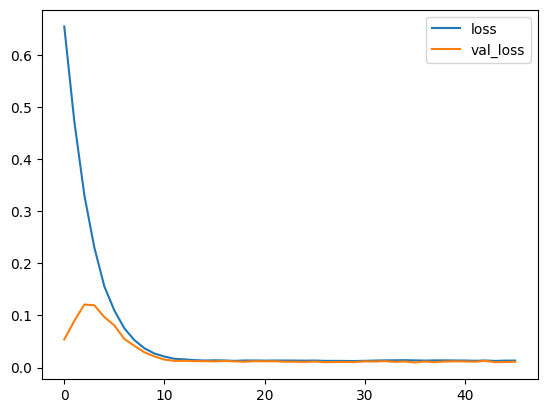

In [12]:
# vẽ biểu đồ mất mát trong quá trình hội tụ
loss = pd.DataFrame(srcnn.history.history)
loss.plot()

1/1 [==============================] - 0s 120ms/step


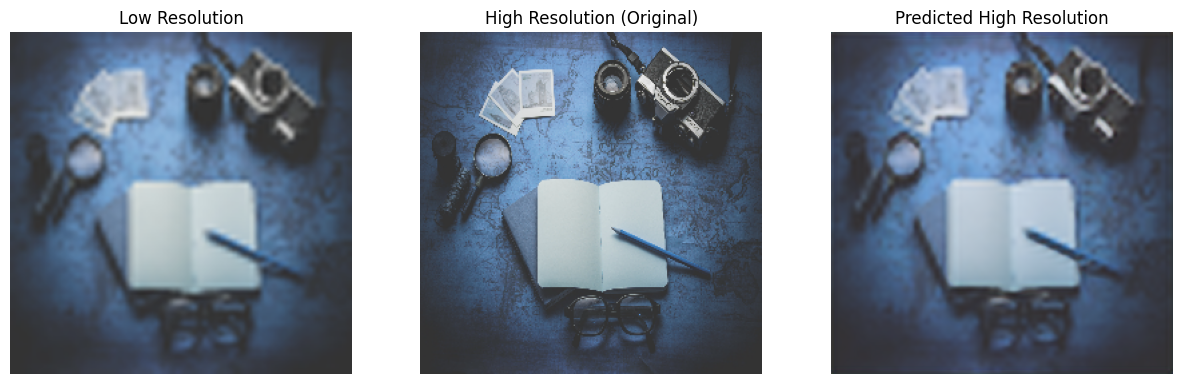

In [13]:

# Load the best model
model = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/srcnn.keras')

# Lấy một batch từ train_dataset
for lr, hr in train_dataset.take(1):
    low_res_sample = lr
    high_res_sample = hr


# Dự đoán ảnh chất lượng cao từ ảnh chất lượng thấp
predicted_high_res = model.predict(low_res_sample)

# Hiển thị ảnh chất lượng cao gốc, ảnh chất lượng thấp, và ảnh được dự đoán
plt.figure(figsize=(15, 5))

# Ảnh chất lượng thấp
plt.subplot(1, 3, 1)
plt.title("Low Resolution")
plt.imshow(low_res_sample[0])
plt.axis("off")

# Ảnh chất lượng cao gốc
plt.subplot(1, 3, 2)
plt.title("High Resolution (Original)")
plt.imshow(high_res_sample[0])
plt.axis("off")


# Ảnh được dự đoán
plt.subplot(1, 3, 3)
plt.title("Predicted High Resolution")
plt.imshow(predicted_high_res[0])
plt.axis("off")

plt.show()
